In [1]:
import sys

MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data
import tqdm
from sklearn.preprocessing import MinMaxScaler

In [3]:
from utils.dataset import SlowEarthquakeDataset
from utils.nn_io import save_model

In [4]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [5]:
EXPERIMENT = "p4581"
TS_COLUMN = "det_shear_stress"

dataset = SlowEarthquakeDataset([EXPERIMENT])
ds_exp = dataset[EXPERIMENT]
X, Y, t = ds_exp["X"], ds_exp["Y"], ds_exp["t"]

ts_data = pd.DataFrame(
    np.hstack((X, Y, t.reshape(-1, 1))),
    columns=[ds_exp["hdrs"]["X"], *ds_exp["hdrs"]["Y"], ds_exp["hdrs"]["t"]],
)

ts_data = ts_data.dropna(axis=1)
ts_data.head()

,det_shear_stress,obs_shear_stress,obs_normal_stress,time
0,0.002811,1.29911,2.99288,0.000
1,0.002731,1.29903,2.99008,0.001
2,0.002231,1.29853,2.98854,0.002
3,0.002411,1.29871,2.98849,0.003
4,0.002241,1.29854,2.99069,0.004


In [6]:
ts_data = ts_data.rolling(window=int(1e3), step=int(1e3)).mean().dropna()
ts_data = ts_data.reset_index(drop=True)
ts_data = ts_data.dropna()
ts_data.head()

,det_shear_stress,obs_shear_stress,obs_normal_stress,time
0,0.010441,1.306805,2.989703,0.500503
1,0.023812,1.320308,2.989567,1.500508
2,0.033829,1.330455,2.989649,2.500513
3,0.040971,1.337728,2.989704,3.500518
4,0.045985,1.342874,2.989764,4.500523


In [7]:
# AIRLINES_CSV_URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
# TS_COLUMN = "Passengers"

# ts_data = pd.read_csv(AIRLINES_CSV_URL)
# ts_data.head()

In [15]:
def create_sequences(data, lookback, forecast):
    xs, ys = [], []
    for i in range(len(data) - lookback - forecast + 1):
        x = data[i : (i + lookback)]
        y = data[(i + lookback) : (i + lookback + forecast)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


lookback = 5
forecast = 1

X, y = create_sequences(ts_data[TS_COLUMN].values, lookback, forecast)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

train_size = int(len(y) * 0.8)
X_train_sc, X_test_sc = scaler_X.fit_transform(
    X[:train_size]
), scaler_X.transform(X[train_size:])
y_train_sc, y_test_sc = scaler_y.fit_transform(
    y[:train_size]
), scaler_y.transform(y[train_size:])

y_train = torch.Tensor(y[:train_size])
y_test = torch.Tensor(y[train_size:])

X_train_sc = torch.from_numpy(X_train_sc).float().to(device)
y_train_sc = torch.from_numpy(y_train_sc).float().to(device)
X_test_sc = torch.from_numpy(X_test_sc).float().to(device)
y_test_sc = torch.from_numpy(y_test_sc).float().to(device)

loader = data.DataLoader(
    data.TensorDataset(X_train_sc, y_train_sc), shuffle=True, batch_size=64
)

using device: cuda


In [9]:
from utils.models.tcn import TemporalConvNet


class TCN(nn.Module):
    def __init__(
        self,
        n_variates,
        seq_length,
        output_steps,
        hidden_size,
        kernel_size,
        dropout,
    ):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(
            num_inputs=n_variates,
            num_channels=hidden_size,
            kernel_size=kernel_size,
            dropout=dropout,
        )
        self.fc1 = nn.Linear(hidden_size[-1] * seq_length, 128)
        self.fc2 = nn.Linear(128, output_steps)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.tcn(x.transpose(1, 2)).transpose(1, 2)
        out = out.reshape(x.size(0), hidden_size[-1] * x.size(1))
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out


n_variates = 1
seq_length = lookback
hidden_size = [50]
output_steps = forecast
kernel_size = 2
dropout = 0

model = TCN(
    n_variates, seq_length, output_steps, hidden_size, kernel_size, dropout
).to(device)

In [10]:
learning_rate = 1e-3
num_epochs = int(5e2)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

pbar = tqdm.tqdm(range(num_epochs))

for epoch in pbar:

    model.train()
    for X_batch, y_batch in loader:
        outputs = model(X_batch.unsqueeze(-1))
        optimizer.zero_grad()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()

    with torch.no_grad():
        y_pred = model(X_train_sc.unsqueeze(-1))
        y_pred = torch.Tensor(scaler_y.inverse_transform(y_pred.cpu()))
        train_rmse = np.sqrt(criterion(y_pred, y_train))

        y_pred = model(X_test_sc.unsqueeze(-1))
        y_pred = torch.Tensor(scaler_y.inverse_transform(y_pred.cpu()))
        test_rmse = np.sqrt(criterion(y_pred, y_test))

    pbar.set_description(
        f"Epoch [{epoch+1}/{num_epochs}], Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}"
    )

Epoch [500/500], Train RMSE: 0.0379, Test RMSE: 0.0413: 100%|█| 500/500 


In [11]:
with torch.no_grad():
    y_pred = model(X_test_sc.unsqueeze(-1))
    y_pred = torch.Tensor(scaler_y.inverse_transform(y_pred.cpu()))
    test_rmse = np.sqrt(criterion(y_pred, y_test))
    print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 0.0413


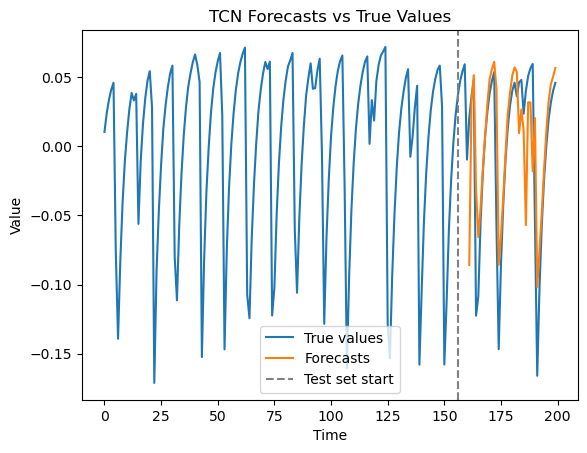

In [12]:
with torch.no_grad():
    train_outputs = scaler_y.inverse_transform(
        model(X_train_sc.unsqueeze(-1)).cpu().numpy()
    )
    test_outputs = y_pred

train_outputs = np.array(
    [train_outputs[idx] for idx in range(0, len(train_outputs), forecast)]
).reshape(-1, 1)
train_outputs = train_outputs[: len(train_outputs) - 1 * (forecast - 1)]

train_outputs = [[np.nan] for x in train_outputs]
test_outputs = np.array(
    [test_outputs[idx] for idx in range(0, len(test_outputs), forecast)]
).reshape(-1, 1)

all_outputs = np.concatenate((train_outputs, test_outputs))

test_start_index = len(ts_data) - len(y_test) - lookback

plt.plot(ts_data[TS_COLUMN].values, label="True values")
plt.plot(
    range(lookback, lookback + len(all_outputs)),
    all_outputs,
    label="Forecasts",
)
plt.axvline(
    x=test_start_index, color="gray", linestyle="--", label="Test set start"
)
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("TCN Forecasts vs True Values")
plt.show()

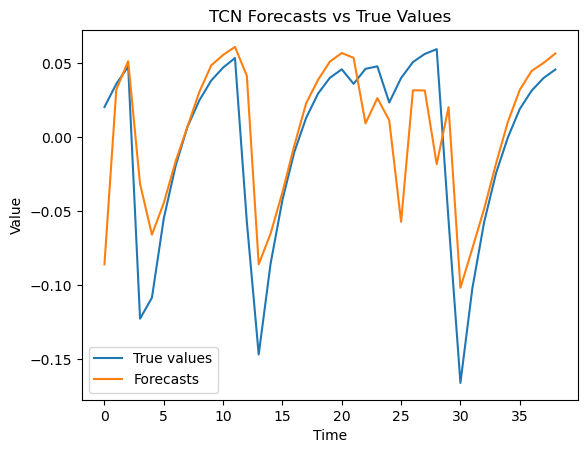

In [13]:
plt.plot(y_test, label="True values")
plt.plot(y_pred, label="Forecasts")

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("TCN Forecasts vs True Values")
plt.show()

In [14]:
save_model(
    model,
    ts_data[TS_COLUMN].values,
    pred=all_outputs,
    pred_index=range(lookback, lookback + len(all_outputs)),
)

model saved to /gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/results/p341cam_2024-01-22T16:41:30_model.pth
input, predictions and forecasts saved to /gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/results/p341cam_2024-01-22T16:41:30_data.pt
